# HPC Anomaly Detection: GNN training

## Preliminary steps

In [1]:
! pip install dgl torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 26.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=3d89ab583a4649e57dc6171df51d899127d15dd4aaeb1787a923961dd5d7bb2d
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! if ! [ -d data ]; then cp -r drive/MyDrive/HPCDATA/data .; fi

In [4]:
import itertools
import json
import logging
import os
import shutil
import random
from timeit import default_timer

import dgl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (auc, roc_curve, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report,
                             precision_recall_curve)

from torch import nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from tqdm.notebook import tqdm

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## Reproducibility

In [ ]:
RANDOM_SEED = None # Set a random seed to allow for reproducibility (it will slow down computations)

def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  os.environ['CUBLAS_WORKSPACE_CONFIG']=':16:8'

def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

g = None
if RANDOM_SEED is not None:
  g = torch.Generator()
  g.manual_seed(RANDOM_SEED)
  set_reproducibility(RANDOM_SEED)

## Read node metrics

In [ ]:
AGGREGATED_METRICS_PATH = "data/aggregated/"

# Read all dataframes
df_list = []
for i in tqdm(range(49)):
    df_list.append(pd.read_parquet(os.path.join(AGGREGATED_METRICS_PATH,f'rack_{i}.parquet')).rename(columns={'values':f'values_{i}'}))

# Aggregate all dataframes into a single one
data = df_list[0]
for df in tqdm(df_list[1:]):
    data = pd.merge(data,df,how='outer',on='timestamp')

# Aggregate values
values_columns = [f'values_{i}' for i in range(49)]
data['values']= data[values_columns].agg(np.concatenate,axis=1)
data = data.drop(values_columns,axis=1)

node_columns = data.columns[1:-1]
num_node_features = data[node_columns[0]][0].shape[0]

# Free some space deallocating variables not used anymore
del df_list

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

### Filter out null values

In [ ]:
DROP_TH = 100
KEEPNODES = np.arange(460,559).astype(str) # set it no None if you don't want to filter nodes

# Drop columns with more than DROP_TH null values
to_drop = data.columns[data.isnull().sum()>DROP_TH].to_list()
if KEEPNODES is not None:
  to_drop += [n for n in node_columns if n not in KEEPNODES]

data = data.drop(to_drop,axis=1).dropna()

# Remove elements relative to dropped columns from the 'values' column and build the 'anomalies' column
mask = np.ones(len(node_columns),dtype=bool)
for n in to_drop:
    mask[node_columns==n] = 0
data['values'] = data['values'].apply(lambda x : x[mask].astype(int))
data['anomalies'] = data['values'].apply(lambda x : (x>0)|(np.isnan(x)).astype(int))

### Build labels

In [ ]:
WINDOW_SIZE = 10

# Apply a sliding window to compute for each node if it raised an anomaly within the window
labels = []
for i in tqdm(range(len(data))):
    if i+WINDOW_SIZE<len(data):
        anomalies = np.stack(data['anomalies'].iloc[i:i+WINDOW_SIZE].values)
        labels.append(anomalies.any(axis=0).astype(int))
    else: # Put them to zero when the number of samples is less than the window size, no relevant data come from here
        labels.append(np.zeros(data['anomalies'][0].shape))
data['labels'] = labels

  0%|          | 0/2963 [00:00<?, ?it/s]

### Rescale Values

In [ ]:
node_columns = data.columns[1:-3] #Reassing it after having dropped some node column

maximum = np.max(np.stack([np.max(np.stack(data[column].values),axis=0) for column in node_columns]),axis=0)
minimum = np.min(np.stack([np.min(np.stack(data[column].values),axis=0) for column in node_columns]),axis=0)

class MinMaxScaler():
    def __init__(self,min,max,range_min = 0, range_max=1):
        self.min = min
        self.max = max
        if range_max-range_min <=0:
            raise ValueError("Invalid output range encountered. range_max - range_min =",range_max-range_min)
        self.range_min = range_min
        self.range_max = range_max
        self.mask = np.where(self.max != self.min)

    def __call__(self, x):
        x_std = (x -self.min)
        x_std[self.mask] /= (self.max[self.mask]-self.min[self.mask])
        return x_std * (self.range_max-self.range_min) + self.range_min

scaler = MinMaxScaler(minimum,maximum)
data[node_columns] = data[node_columns].applymap(scaler)
data.head()

timestamp  \
0 2022-03-31 02:45:00+00:00   
1 2022-03-31 03:00:00+00:00   
2 2022-03-31 03:15:00+00:00   
3 2022-03-31 03:30:00+00:00   
4 2022-03-31 03:45:00+00:00   

                                                 460  \
0  [0.539976015665201, 0.5405405022263785, 0.5315...   
1  [0.5129274204992378, 0.5045045002473754, 0.522...   
2  [0.5151152414633041, 0.5045045002473754, 0.522...   
3  [0.5079552656588584, 0.5045045002473754, 0.513...   
4  [0.49940312291625616, 0.4954954567943217, 0.50...   

                                                 461  \
0  [0.3955845662662844, 0.40540536593020815, 0.37...   
1  [0.3570007782344892, 0.3513513629617035, 0.360...   
2  [0.360381867804047, 0.3513513629617035, 0.3603...   
3  [0.3534208510275159, 0.3513513629617035, 0.360...   
4  [0.3424821103786812, 0.3423423195086498, 0.342...   

                                                 463  \
0  [0.4160699413210467, 0.43243241037276337, 0.38...   
1  [0.3747015766319405, 0.36936936395120507, 0.37...   
2  [0.37708811384292334, 0.3783784074042587, 0.37...   
3  [0.3729116130284538, 0.3783784074042587, 0.378...   
4  [0.36137611668637437, 0.36936936395120507, 0.3...   

                                                 464  \
0  [0.46081933488446114, 0.47747745580482015, 0.4...   
1  [0.41865537686469456, 0.4144144093832618, 0.42...   
2  [0.4196496864422715, 0.4234234528363155, 0.423...   
3  [0.4188542751973597, 0.4234234528363155, 0.414...   
4  [0.4061256316402878, 0.4144144093832618, 0.405...   

                                                 465  \
0  [0.4759347584335139, 0.48648649925787385, 0.45...   
1  [0.4331741661110016, 0.4234234528363155, 0.432...   
2  [0.4321796744476762, 0.43243241037276337, 0.43...   
3  [0.4349641904097378, 0.45045041136226494, 0.43...   
4  [0.4222354861574164, 0.43243241037276337, 0.42...   

                                                 467  \
0  [0.5871120678300974, 0.6036036345645427, 0.576...   
1  [0.5624501919608657, 0.5585585891324859, 0.558...   
2  [0.5626489689030316, 0.5675675466689337, 0.558...   
3  [0.5670245501359148, 0.5675675466689337, 0.558...   
4  [0.5546935818536741, 0.5675675466689337, 0.549...   

                                                 468  \
0  [0.5280428440482905, 0.5495495456794321, 0.504...   
1  [0.49602203334669837, 0.4954954567943217, 0.49...   
2  [0.492442227530224, 0.4954954567943217, 0.4774...   
3  [0.4996021426394202, 0.5135135437004291, 0.495...   
4  [0.48468561742303257, 0.4954954567943217, 0.47...   

                                                 469  \
0  [0.5684167170740713, 0.5945945911114889, 0.540...   
1  [0.5397770566372865, 0.5495495456794321, 0.531...   
2  [0.5385837880317951, 0.5495495456794321, 0.522...   
3  [0.5459426014736564, 0.5585585891324859, 0.540...   
4  [0.5310261369525181, 0.5495495456794321, 0.522...   

                                                 470  ...  \
0  [0.612370456611576, 0.6216216355540441, 0.6036...  ...   
1  [0.590095239343826, 0.5855855476584353, 0.5945...  ...   
2  [0.5922830603078925, 0.6036036345645427, 0.594...  ...   
3  [0.5956641498774502, 0.5945945911114889, 0.594...  ...   
4  [0.5839298158979552, 0.6036036345645427, 0.576...  ...   

                                                 552  \
0  [0.7486076813237196, 0.7477477283971609, 0.747...   
1  [0.7482098846583893, 0.7477477283971609, 0.738...   
2  [0.7400557206668658, 0.7387387708607129, 0.738...   
3  [0.7452264703636629, 0.7477477283971609, 0.747...   
4  [0.7464198603596534, 0.7477477283971609, 0.747...   

                                                 553  \
0  [0.7484088436863042, 0.7477477283971609, 0.756...   
1  [0.749403031873382, 0.7477477283971609, 0.7567...   
2  [0.7420443398220197, 0.7387387708607129, 0.747...   
3  [0.7452264703636629, 0.7387387708607129, 0.756...   
4  [0.7454255507820764, 0.7387387708607129, 0.747...   

                                                 554  \
0  [0.7758549927365993, 0.783783816292

## Read job table and build global graph

In [5]:
JOB_TABLE_PATH = 'data/job_table.parquet'
df = pd.read_parquet(JOB_TABLE_PATH)
df.head()

accrue_time alloc_node  alloc_sid  array_job_id  array_max_tasks  \
0         NaT       None        NaN       1545290              NaN   
1         NaT       None        NaN       4840800              NaN   
2         NaT       None        NaN       3928180              NaN   
3         NaT       None        NaN       4055635              NaN   
4         NaT       None        NaN       5945770              NaN   

   array_task_id array_task_str  array_task_throttle  assoc_id  batch_flag  \
0            NaN           None                  NaN       NaN         NaN   
1            NaN           None                  NaN       NaN         NaN   
2            NaN           None                  NaN       NaN         NaN   
3            NaN           None                  NaN       NaN         NaN   
4            NaN           None                  NaN       NaN         NaN   

   ... tres_bind  tres_freq  tres_per_job  tres_per_node  tres_per_socket  \
0  ...      None       None          None     gres:gpu:1             None   
1  ...      None       None          None     gres:gpu:1             None   
2  ...      None       None          None     gres:gpu:1             None   
3  ...      None       None          None     gres:gpu:4             None   
4  ...      None       None          None     gres:gpu:1             None   

   tres_per_task tres_req_str user_id  wait4switch wckey  
0           None         None     393          NaN  None  
1           None         None     393          NaN  None  
2           None         None    1234          NaN  None  
3           None         None    1318          NaN  None  
4           None         None    1234          NaN  None  

[5 rows x 89 columns]

In [ ]:
df = df.dropna(subset=['nodes'])
print("Data covering the period from {} to {}".format(df.start_time.min().date(),df.end_time.max().date()))
df['duration'] = df.end_time-df.start_time
df.nodes = df.nodes.map(lambda x:np.fromstring(x.strip(']['),dtype=int,sep=',')) # map nodelist from str to array
edge_list = df.nodes.map(lambda x: list(itertools.permutations(x,2))) # build edgelist for each node
true_edges = np.concatenate((edge_list[edge_list.map(len) > 0]).values) # remove empty list and collect all

Data covering the period from 2022-03-31 to 2022-04-30


<ipython-input-11-f9d342059fa6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration'] = df.end_time-df.start_time


In [ ]:
def build_heatmap(edges):
    # Find the maximum node index to determine the dimensions of the heatmap matrix
    max_node = np.max(edges)

    # Initialize the heatmap matrix with zeros
    heatmap = np.zeros((max_node + 1, max_node + 1), dtype=int)

    # Increment the corresponding cells in the heatmap matrix
    np.add.at(heatmap, (edges[:, 0], edges[:, 1]), 1)
    return heatmap

In [ ]:
# Build the heatmap
heatmap = build_heatmap(true_edges)

# Build The global graph
src,dst = np.nonzero(heatmap)
eweights = torch.tensor(heatmap[heatmap.nonzero()],dtype=torch.float32)

nweights = torch.tensor([np.count_nonzero(true_edges.reshape(-1) == i) for i in range(980)])

graph = dgl.graph((src,dst),num_nodes=980)
graph.ndata['nweight'] = nweights
graph.edata['eweight'] = eweights

# Drop nodes not contained in the dataset
drop_nids = [i for i in range(980) if str(i) not in data.columns]
graph = dgl.remove_nodes(graph, drop_nids, store_ids=True)

# Graph is changes, so are the weights
nweights = graph.ndata['nweight']
eweights = graph.edata['eweight']

del df,edge_list,true_edges

## Train/Test split

In [ ]:
import gc
gc.collect()

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.0

data = data[:len(data)-WINDOW_SIZE].drop(['timestamp','values','anomalies'],axis=1)

train_size = int(len(data)*TRAIN_SPLIT)
val_size = train_size + int(len(data)*VAL_SPLIT)

data_list = []

edge_index = torch.stack(graph.edges())

for i,row in tqdm(data.iterrows(), total=len(data)):
    x = torch.tensor(np.stack(row.iloc[:-1]),dtype = torch.float32)
    y = torch.tensor(row.iloc[-1],dtype=torch.float32)
    g = Data(edge_index=edge_index,x=x, y=y,node_weight=nweights)
    g.edge_weight = eweights
    data_list.append(g)

train_data = data_list[:train_size]
# val_data = data_list[train_size:val_size]
test_data = data_list[val_size:]

del data

  0%|          | 0/2953 [00:00<?, ?it/s]

## Model Definition & Training Setup

In [ ]:
class anomaly_anticipation(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #encoder
        self.conv1 = GCNConv(in_channels, 300)
        self.conv2 = GCNConv(300, 100)
        self.conv3 = GCNConv(100, out_channels)

        #dense layer
        self.fc1 = torch.nn.Linear(out_channels,16)
        self.fc2 = torch.nn.Linear(16,1)

    def forward(self, x, edge_index,edge_weight=None):
        x = self.conv1(x, edge_index,edge_weight).relu()
        x = self.conv2(x, edge_index,edge_weight).relu()
        x = self.conv3(x, edge_index,edge_weight).relu()
        x = self.fc1(x)
        x = self.fc2(x)
        return x

 ## Train procedure definition

In [ ]:
logger = logging.getLogger("GNN_trainer")

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



def train_one_step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    dataloader: tuple,
    device: torch.cuda.device | str = 'cuda',
):
    model.train()

    total_num_samples = 0
    avg_acc = 0
    avg_loss = torch.zeros(1)

    start = default_timer()

    for g in tqdm(dataloader,position=1, leave=False):
        optimizer.zero_grad()

        g = g.to(device)
        y = g.y

        # Forward pass
        logits = model(g.x,g.edge_index,g.edge_weight).squeeze()

        # Compute loss
        loss = criterion(logits, y)

        # Compute prediction
        pred = (logits>0.5).int()
        acc = (pred == y).float().mean()

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update metrics
        num_samples = y.numel()
        avg_loss += loss.detach().cpu() * num_samples
        avg_acc += acc * num_samples
        total_num_samples += num_samples

        optimizer.zero_grad()


    stop = default_timer()

    avg_loss = avg_loss.cpu().item() / total_num_samples
    avg_acc = avg_acc.cpu().item() / total_num_samples
    epoch_time = stop - start


    return avg_loss, avg_acc, epoch_time

class StreamingJSONWriter:
    """
    Serialize streaming data to JSON.

    This class holds onto an open file reference to which it carefully
    appends new JSON data. Individual entries are input in a list, and
    after every entry the list is closed so that it remains valid JSON.
    When a new item is added, the file cursor is moved backwards to overwrite
    the list closing bracket.
    """

    def __init__(self, filename, encoder=json.JSONEncoder):
        if os.path.exists(filename):
            self.file = open(filename, "r+")
            self.delimeter = ","
        else:
            self.file = open(filename, "w")
            self.delimeter = "["
        self.encoder = encoder

    def dump(self, obj):
        """
        Dump a JSON-serializable object to file.
        """
        data = json.dumps(obj, cls=self.encoder)
        close_str = "\n]\n"
        self.file.seek(max(self.file.seek(0, os.SEEK_END) - len(close_str), 0))
        self.file.write(f"{self.delimeter}\n    {data}{close_str}")
        self.file.flush()
        self.delimeter = ","

    def close(self):
        self.file.close()


class MyTrainer:
    def __init__(self,
                 model: nn.Module,
                 optimizer: torch.optim.Optimizer,
                 scheduler: torch.optim.lr_scheduler,
                es_patience: int,
                es_min_delta: float,) -> None:
        """
        Parameters:
        model: MEGNet model
        optimizer: torch Optimizer
        """
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.early_stopper = None
        if es_patience > 0 :
             self.early_stopper = EarlyStopper(es_patience,es_min_delta)


    def train(
        self,
        num_epochs: int,
        train_loss_func: nn.Module,
        train_loader: tuple,
        logger_name: str,
        device: torch.cuda.device | str = 'cpu',
        path: str = None,
    ) -> None:

        if path is None: path = os.getcwd()
        if not os.path.exists(path):
             os.mkdir(path)
        # Set a path for best model and checkpoints
        outpath = os.path.join(path, "BestModel")
        checkpath = os.path.join(path, "CheckPoints")
        if os.path.exists(outpath):
            shutil.rmtree(outpath)
        os.mkdir(outpath)
        if os.path.exists(checkpath):
            shutil.rmtree(checkpath)
        os.mkdir(checkpath)
        jsonlog = StreamingJSONWriter(filename=logger_name)
        logger.info("## Training started ##")
        best_loss = np.inf
        for epoch in tqdm(range(num_epochs),position=0):

            loss,acc, train_time = train_one_step(
                self.model,
                self.optimizer,
                train_loss_func,
                train_loader,
                device = device,
                )


            self.scheduler.step()
            logger.info(
                f"Epoch: {epoch + 1:03} Loss: {loss:.4f} Acc: {acc:.2f}"
            )

            if loss < best_loss:
                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model": self.model.state_dict(),
                        "optimizer_state_dict": self.optimizer.state_dict(),
                        "scheduler_state_dict": self.scheduler.state_dict(),
                        "loss": loss,
                        "acc": acc,

                    },
                    checkpath + "/%05d" % (epoch + 1) + "-%6.5f" % (loss) + ".pt",
                )

                log_dict = {
                    "Epoch": epoch + 1,
                    "train_loss": loss,
                    "train_acc":acc,
                    "train_time": train_time,
                }

                jsonlog.dump(log_dict)
                best_loss = loss
                torch.save({"model": self.model.state_dict()}, outpath + "/best-model.pt")

            if self.early_stopper is not None and self.early_stopper.early_stop(validation_loss=loss):
                            tqdm.write('Early Stopping')
                            break
            tqdm.write(f'Epoch {epoch+1}/{num_epochs}\t Train Loss: {loss}, Train Acc at 50%: {acc}')
        jsonlog.close()
        logger.info("## Training complete ##")


## Train

In [ ]:
NUM_EPOCHS = 500
INITIAL_LR = 1e-3

TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1

ES_PATIENCE = 100
ES_MIN_DELTA = 0
LOGGER_NAME = f'out/train.output'
LOGPATH = f'out'

APPLY_WEIGHT_BALANCING = True # whether to use weight balancing inside the loss

# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Available device:',device)

# Create model
in_channels, out_channels = num_node_features, 16
model = anomaly_anticipation(in_channels,out_channels).to(device)

# Prepare dataloaders
train_loader = DataLoader(train_data, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_data, shuffle = False)

# Compute weight balancing
pos_weight = None
if APPLY_WEIGHT_BALANCING:
  train_labels = torch.cat([g.y for g in train_data])
  train_ones = len(train_labels.nonzero())
  train_zeros = len(train_labels)-train_ones
  pos_weight = torch.tensor(train_zeros/train_ones)
  # pos_weight = torch.tensor(train_ones/train_zeros)


# Set up training
criterion = torch.nn.BCEWithLogitsLoss(weight = pos_weight*100)
optimizer = torch.optim.Adam([p for p in model.parameters()],lr = INITIAL_LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=NUM_EPOCHS,eta_min=INITIAL_LR * 1e-1)
trainer =  MyTrainer(model,
                     optimizer,
                     scheduler,
                     ES_PATIENCE,
                     ES_MIN_DELTA)


Available device: cuda


In [ ]:
# Train
trainer.train(NUM_EPOCHS,criterion,train_loader,LOGGER_NAME,device,LOGPATH)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/500	 Train Loss: 1906.9604123917723, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/500	 Train Loss: 746.4264384498607, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/500	 Train Loss: 677.0131180176724, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/500	 Train Loss: 681.5983184024824, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/500	 Train Loss: 685.1279382079642, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/500	 Train Loss: 686.9084741615646, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/500	 Train Loss: 688.3221727307609, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8/500	 Train Loss: 689.3263266770098, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/500	 Train Loss: 689.9510979875326, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/500	 Train Loss: 690.4257266625516, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11/500	 Train Loss: 690.0880725578188, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12/500	 Train Loss: 691.9521990335263, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13/500	 Train Loss: 689.6339967413487, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14/500	 Train Loss: 689.6495670887343, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15/500	 Train Loss: 688.9457873869064, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16/500	 Train Loss: 688.5762363133866, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 17/500	 Train Loss: 687.9590722297294, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 18/500	 Train Loss: 687.2699286544439, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 19/500	 Train Loss: 686.5387006545106, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 20/500	 Train Loss: 685.7680129456317, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 21/500	 Train Loss: 684.9604902435091, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22/500	 Train Loss: 684.1198694315154, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 23/500	 Train Loss: 683.1896079052879, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 24/500	 Train Loss: 672.6147618014892, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 25/500	 Train Loss: 668.4089440524053, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 26/500	 Train Loss: 678.3643127637922, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 27/500	 Train Loss: 681.6650039759994, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 28/500	 Train Loss: 679.7526983968103, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 29/500	 Train Loss: 675.1000116777606, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 30/500	 Train Loss: 673.1187072163, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 31/500	 Train Loss: 677.3599808707161, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 32/500	 Train Loss: 676.5698969576654, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 33/500	 Train Loss: 674.9748705714874, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 34/500	 Train Loss: 673.5086332015414, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 35/500	 Train Loss: 672.1207369222984, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 36/500	 Train Loss: 670.7775052966986, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 37/500	 Train Loss: 669.4673717809696, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 38/500	 Train Loss: 668.1333044169739, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 39/500	 Train Loss: 666.7863803947083, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 40/500	 Train Loss: 665.4720651285388, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 41/500	 Train Loss: 664.0516045799064, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 42/500	 Train Loss: 662.7138893059517, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 43/500	 Train Loss: 661.2767462422635, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 44/500	 Train Loss: 659.809930545129, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 45/500	 Train Loss: 658.3033437321011, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 46/500	 Train Loss: 656.7640147028566, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 47/500	 Train Loss: 655.18629364563, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 48/500	 Train Loss: 653.5671109776509, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 49/500	 Train Loss: 651.9202130913256, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 50/500	 Train Loss: 650.1560482458335, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 51/500	 Train Loss: 648.3108286205228, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 52/500	 Train Loss: 646.7926307770159, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 53/500	 Train Loss: 644.9473666649984, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 54/500	 Train Loss: 642.9922648738524, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 55/500	 Train Loss: 641.1195969504363, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 56/500	 Train Loss: 639.1834909831006, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 57/500	 Train Loss: 637.0217484387946, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 58/500	 Train Loss: 635.1455215788333, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 59/500	 Train Loss: 633.0243509111434, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 60/500	 Train Loss: 630.8730627429392, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 61/500	 Train Loss: 627.9705275567345, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 62/500	 Train Loss: 626.2210878111985, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 63/500	 Train Loss: 624.8733630282102, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 64/500	 Train Loss: 622.4440329424064, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 65/500	 Train Loss: 620.1578165924295, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 66/500	 Train Loss: 617.9677805025885, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 67/500	 Train Loss: 615.6558508360721, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 68/500	 Train Loss: 613.3953922893415, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 69/500	 Train Loss: 611.1972151321534, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 70/500	 Train Loss: 608.856947433395, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 71/500	 Train Loss: 606.8444133037497, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 72/500	 Train Loss: 604.5745235751742, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 73/500	 Train Loss: 602.5828537110255, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 74/500	 Train Loss: 600.4890423680274, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 75/500	 Train Loss: 598.1204366370274, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 76/500	 Train Loss: 596.3212162665643, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 77/500	 Train Loss: 594.4902768741415, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 78/500	 Train Loss: 592.2010799148079, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 79/500	 Train Loss: 590.5019991213875, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 80/500	 Train Loss: 588.2709462878623, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 81/500	 Train Loss: 586.6477153295631, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 82/500	 Train Loss: 584.4488708717727, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 83/500	 Train Loss: 583.163605425154, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 84/500	 Train Loss: 580.7879263077701, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 85/500	 Train Loss: 580.5562395386728, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 86/500	 Train Loss: 579.0015181088701, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 87/500	 Train Loss: 577.4078263238966, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 88/500	 Train Loss: 575.5071762618933, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 89/500	 Train Loss: 573.8886164078096, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 90/500	 Train Loss: 572.8954061914375, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 91/500	 Train Loss: 571.6383008302332, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 92/500	 Train Loss: 569.972273659977, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 93/500	 Train Loss: 569.077112145427, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 94/500	 Train Loss: 568.8263850658125, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 95/500	 Train Loss: 567.5113135256271, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 96/500	 Train Loss: 565.9792358295937, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 97/500	 Train Loss: 565.5872634558386, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 98/500	 Train Loss: 564.7966012155993, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 99/500	 Train Loss: 564.3124968720284, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 100/500	 Train Loss: 568.8516535152839, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 101/500	 Train Loss: 562.0005227188051, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 102/500	 Train Loss: 565.9665571181512, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 103/500	 Train Loss: 562.5374327833664, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 104/500	 Train Loss: 562.1940843801611, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 105/500	 Train Loss: 561.9677360158818, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 106/500	 Train Loss: 561.9391310633991, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 107/500	 Train Loss: 561.7528652219609, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 108/500	 Train Loss: 561.7211462000012, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 109/500	 Train Loss: 561.6701199472833, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 110/500	 Train Loss: 561.6431610029528, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 111/500	 Train Loss: 561.609262132359, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 112/500	 Train Loss: 561.5559670575936, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 113/500	 Train Loss: 561.5797674457401, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 114/500	 Train Loss: 561.5349248452696, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 115/500	 Train Loss: 561.5160179948729, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 116/500	 Train Loss: 561.5514739002052, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 117/500	 Train Loss: 561.6430275428323, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 118/500	 Train Loss: 561.4514232965762, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 119/500	 Train Loss: 561.513571225998, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 120/500	 Train Loss: 561.3600031140695, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 121/500	 Train Loss: 561.3949696656268, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 122/500	 Train Loss: 561.2981665915953, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 123/500	 Train Loss: 562.571376140667, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 124/500	 Train Loss: 562.1771349448643, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 125/500	 Train Loss: 561.4439495298311, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 126/500	 Train Loss: 561.5043624776871, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 127/500	 Train Loss: 561.307197393079, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 128/500	 Train Loss: 561.5358590661128, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 129/500	 Train Loss: 561.3290403661256, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 130/500	 Train Loss: 561.2732095490716, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 131/500	 Train Loss: 561.3043502438428, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 132/500	 Train Loss: 561.1895745402577, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 133/500	 Train Loss: 561.2693836922855, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 134/500	 Train Loss: 561.0977094906829, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 135/500	 Train Loss: 561.1830349943557, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 136/500	 Train Loss: 561.0410334261993, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 137/500	 Train Loss: 561.1679095140383, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 138/500	 Train Loss: 560.8944052405341, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 139/500	 Train Loss: 561.0823615768313, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 140/500	 Train Loss: 560.8351044603485, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 141/500	 Train Loss: 560.9961463390221, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 142/500	 Train Loss: 560.7234428262404, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 143/500	 Train Loss: 560.9349771171502, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 144/500	 Train Loss: 560.6115587585984, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 145/500	 Train Loss: 560.7670842856269, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 146/500	 Train Loss: 560.5222739380189, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 147/500	 Train Loss: 560.6412758787515, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 148/500	 Train Loss: 560.4998081510769, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 149/500	 Train Loss: 560.5178697540441, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 150/500	 Train Loss: 560.3594525910727, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 151/500	 Train Loss: 560.339567033126, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 152/500	 Train Loss: 560.2225225074932, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 153/500	 Train Loss: 560.273548760211, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 154/500	 Train Loss: 560.1347502349454, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 155/500	 Train Loss: 560.147162026147, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 156/500	 Train Loss: 560.0284270056553, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 157/500	 Train Loss: 560.0353669319187, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 158/500	 Train Loss: 559.778144793109, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 159/500	 Train Loss: 559.7949607682855, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 160/500	 Train Loss: 559.6814306924912, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 161/500	 Train Loss: 559.5174082044609, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 162/500	 Train Loss: 559.4090385866573, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 163/500	 Train Loss: 559.3746058755818, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 164/500	 Train Loss: 559.2771355009481, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 165/500	 Train Loss: 559.1640947789289, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 166/500	 Train Loss: 558.9265357645319, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 167/500	 Train Loss: 559.099767000873, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 168/500	 Train Loss: 558.9371680874609, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 169/500	 Train Loss: 558.859093916999, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 170/500	 Train Loss: 558.4582242018806, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 171/500	 Train Loss: 558.6022721585506, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 172/500	 Train Loss: 558.4659204021598, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 173/500	 Train Loss: 558.4242808445802, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 174/500	 Train Loss: 558.0163377430781, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 175/500	 Train Loss: 557.9917810809158, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 176/500	 Train Loss: 557.7066212902257, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 177/500	 Train Loss: 558.4007918633813, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 178/500	 Train Loss: 557.6659604401959, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 179/500	 Train Loss: 557.9723848767441, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 180/500	 Train Loss: 557.0378971133688, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 181/500	 Train Loss: 557.4672383208492, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 182/500	 Train Loss: 557.0115164962269, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 183/500	 Train Loss: 557.2201146644868, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 184/500	 Train Loss: 557.4235078880492, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 185/500	 Train Loss: 556.7844563446386, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 186/500	 Train Loss: 555.7988978418387, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 187/500	 Train Loss: 556.0021131185738, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 188/500	 Train Loss: 555.6064038614461, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 189/500	 Train Loss: 555.4269889728575, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 190/500	 Train Loss: 554.9681085920513, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 191/500	 Train Loss: 554.7225864571343, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 192/500	 Train Loss: 554.2262037824822, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 193/500	 Train Loss: 553.9268527323179, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 194/500	 Train Loss: 553.3106673562106, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 195/500	 Train Loss: 552.9040143692063, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 196/500	 Train Loss: 552.3327605669831, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 197/500	 Train Loss: 550.8731962030596, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 198/500	 Train Loss: 550.8203904820691, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 199/500	 Train Loss: 550.1403221949741, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 200/500	 Train Loss: 550.2059845742344, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 201/500	 Train Loss: 548.7083395892765, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 202/500	 Train Loss: 548.7118540391149, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 203/500	 Train Loss: 547.3368589048484, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 204/500	 Train Loss: 547.6823426699809, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 205/500	 Train Loss: 546.1379866428663, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 206/500	 Train Loss: 546.1882121348615, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 207/500	 Train Loss: 543.9031969259686, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 208/500	 Train Loss: 544.7443070917371, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 209/500	 Train Loss: 541.5027387128883, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 210/500	 Train Loss: 541.268160307848, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 211/500	 Train Loss: 539.5168076339189, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 212/500	 Train Loss: 538.6861963309589, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 213/500	 Train Loss: 536.1048551679651, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 214/500	 Train Loss: 535.0232943518565, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 215/500	 Train Loss: 532.9604012700955, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 216/500	 Train Loss: 531.4364201547025, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 217/500	 Train Loss: 529.609039698825, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 218/500	 Train Loss: 527.6071378921087, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 219/500	 Train Loss: 526.708506414427, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 220/500	 Train Loss: 524.6800905304484, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 221/500	 Train Loss: 523.4779707388686, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 222/500	 Train Loss: 521.6336408476942, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 223/500	 Train Loss: 520.6151621818506, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 224/500	 Train Loss: 519.1979046761089, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 225/500	 Train Loss: 518.4012367304495, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 226/500	 Train Loss: 517.0258412158217, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 227/500	 Train Loss: 516.5299478949446, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 228/500	 Train Loss: 515.1053055958716, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 229/500	 Train Loss: 514.8257956169472, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 230/500	 Train Loss: 513.0751102436203, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 231/500	 Train Loss: 512.8691812777695, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 232/500	 Train Loss: 511.3241134633457, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 233/500	 Train Loss: 510.6742961368856, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 234/500	 Train Loss: 508.9511925217846, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 235/500	 Train Loss: 508.65606770876775, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 236/500	 Train Loss: 507.5402521284109, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 237/500	 Train Loss: 506.80470891791646, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 238/500	 Train Loss: 505.11937451690216, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 239/500	 Train Loss: 504.47747582425524, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 240/500	 Train Loss: 502.9739585939976, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 241/500	 Train Loss: 502.5746459136179, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 242/500	 Train Loss: 500.9708111594904, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 243/500	 Train Loss: 500.14963103837533, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 244/500	 Train Loss: 498.41936506347696, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 245/500	 Train Loss: 496.9602455666216, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 246/500	 Train Loss: 496.3367643705965, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 247/500	 Train Loss: 495.1454103620662, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 248/500	 Train Loss: 494.3267214965328, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 249/500	 Train Loss: 494.07968681358403, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 250/500	 Train Loss: 494.30136407364773, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 251/500	 Train Loss: 490.85844885975007, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 252/500	 Train Loss: 490.3471631383147, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 253/500	 Train Loss: 488.92852654466185, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 254/500	 Train Loss: 489.63186137942154, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 255/500	 Train Loss: 488.1441814167904, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 256/500	 Train Loss: 486.18205072596743, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 257/500	 Train Loss: 484.36080943563053, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 258/500	 Train Loss: 484.74299473388606, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 259/500	 Train Loss: 488.05600876388127, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 260/500	 Train Loss: 490.42265707978135, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 261/500	 Train Loss: 483.0349721123957, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 262/500	 Train Loss: 483.3105672611203, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 263/500	 Train Loss: 480.92612426249383, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 264/500	 Train Loss: 480.6022610368739, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 265/500	 Train Loss: 478.52308582041826, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 266/500	 Train Loss: 477.438055041178, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 267/500	 Train Loss: 475.058816987249, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 268/500	 Train Loss: 475.8317290314688, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 269/500	 Train Loss: 473.16710875331563, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 270/500	 Train Loss: 472.3598084847272, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 271/500	 Train Loss: 471.5945036673729, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 272/500	 Train Loss: 470.0830233165952, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 273/500	 Train Loss: 468.2882071301069, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 274/500	 Train Loss: 468.4601037652437, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 275/500	 Train Loss: 469.6694748900344, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 276/500	 Train Loss: 467.6386122371809, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 277/500	 Train Loss: 465.4106734731328, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 278/500	 Train Loss: 462.9357889995496, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 279/500	 Train Loss: 462.48438238548846, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 280/500	 Train Loss: 460.4945364763192, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 281/500	 Train Loss: 459.87906288752094, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 282/500	 Train Loss: 458.554693625611, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 283/500	 Train Loss: 457.9907356433056, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 284/500	 Train Loss: 456.50826062537186, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 285/500	 Train Loss: 455.7434896484994, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 286/500	 Train Loss: 454.4221899693598, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 287/500	 Train Loss: 453.96495559670575, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 288/500	 Train Loss: 452.6084224457679, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 289/500	 Train Loss: 452.20150253852273, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 290/500	 Train Loss: 450.9690428128945, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 291/500	 Train Loss: 450.5941533345567, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 292/500	 Train Loss: 449.45133432316254, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 293/500	 Train Loss: 449.2843312257756, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 294/500	 Train Loss: 448.5429602566883, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 295/500	 Train Loss: 450.1804714478755, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 296/500	 Train Loss: 452.55873079425453, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 297/500	 Train Loss: 458.9412386211345, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 298/500	 Train Loss: 458.6153734937079, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 299/500	 Train Loss: 450.31495476258, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 300/500	 Train Loss: 450.8855857509078, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 301/500	 Train Loss: 448.6060424069533, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 302/500	 Train Loss: 444.1595960607021, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 303/500	 Train Loss: 441.669452646681, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 304/500	 Train Loss: 440.1065901495309, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 305/500	 Train Loss: 438.7741243069805, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 306/500	 Train Loss: 437.8605897825156, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 307/500	 Train Loss: 436.78556851230894, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 308/500	 Train Loss: 435.46893993738496, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 309/500	 Train Loss: 434.4206996646814, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 310/500	 Train Loss: 433.5015153284509, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 311/500	 Train Loss: 432.601994116633, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 312/500	 Train Loss: 431.7250721518776, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 313/500	 Train Loss: 430.8486395408972, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 314/500	 Train Loss: 430.08373510390425, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 315/500	 Train Loss: 429.3667873368589, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 316/500	 Train Loss: 428.54529580879614, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 317/500	 Train Loss: 427.8832891246684, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 318/500	 Train Loss: 427.35078324408187, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 319/500	 Train Loss: 426.42101107162915, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 320/500	 Train Loss: 425.4050236613672, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 321/500	 Train Loss: 424.6342469790746, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 322/500	 Train Loss: 423.83192922164943, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 323/500	 Train Loss: 423.19140961691386, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 324/500	 Train Loss: 422.2562545529364, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 325/500	 Train Loss: 421.5802790428685, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 326/500	 Train Loss: 420.74504112239964, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 327/500	 Train Loss: 419.7486278631366, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 328/500	 Train Loss: 419.00534396565627, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 329/500	 Train Loss: 418.4492601304573, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 330/500	 Train Loss: 417.67483553820574, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 331/500	 Train Loss: 417.13449999721956, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 332/500	 Train Loss: 416.4389948228595, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 333/500	 Train Loss: 416.1399996663497, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 334/500	 Train Loss: 415.73592690834073, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 335/500	 Train Loss: 415.49743367310055, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 336/500	 Train Loss: 415.3742499819273, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 337/500	 Train Loss: 413.6666277407982, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 338/500	 Train Loss: 413.0103598418498, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 339/500	 Train Loss: 412.20946565904273, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 340/500	 Train Loss: 411.5700137352707, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 341/500	 Train Loss: 411.41382090764006, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 342/500	 Train Loss: 411.3363250643667, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 343/500	 Train Loss: 410.74803285343296, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 344/500	 Train Loss: 410.1269539395759, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 345/500	 Train Loss: 409.35212896696305, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 346/500	 Train Loss: 408.3810286438783, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 347/500	 Train Loss: 407.6524253596472, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 348/500	 Train Loss: 407.2304244587914, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 349/500	 Train Loss: 406.84045398684304, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 350/500	 Train Loss: 406.49158923199263, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 351/500	 Train Loss: 406.12813283730657, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 352/500	 Train Loss: 405.9332810614528, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 353/500	 Train Loss: 406.24348686808025, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 354/500	 Train Loss: 405.984707694532, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 355/500	 Train Loss: 405.0946176645591, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 356/500	 Train Loss: 404.8280088306113, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 357/500	 Train Loss: 404.2442542637728, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 358/500	 Train Loss: 404.0008230040761, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 359/500	 Train Loss: 403.7474712087594, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 360/500	 Train Loss: 403.44825361871557, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 361/500	 Train Loss: 403.29642048835285, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 362/500	 Train Loss: 403.18395809352216, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 363/500	 Train Loss: 402.8875876527145, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 364/500	 Train Loss: 402.71222105444616, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 365/500	 Train Loss: 402.47261565153565, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 366/500	 Train Loss: 402.08620411613254, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 367/500	 Train Loss: 401.80980820668526, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 368/500	 Train Loss: 401.12907261898806, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 369/500	 Train Loss: 401.0288440685318, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 370/500	 Train Loss: 400.80685540152035, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 371/500	 Train Loss: 400.46097125602654, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 372/500	 Train Loss: 400.4488708717726, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 373/500	 Train Loss: 400.1621095596372, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 374/500	 Train Loss: 399.96334295358366, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 375/500	 Train Loss: 399.63832307358655, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 376/500	 Train Loss: 399.47817092904927, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 377/500	 Train Loss: 399.46380172274775, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 378/500	 Train Loss: 399.3369256349087, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 379/500	 Train Loss: 399.0903358190281, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 380/500	 Train Loss: 398.765315939031, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 381/500	 Train Loss: 398.4870515878974, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 382/500	 Train Loss: 398.3287678850464, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 383/500	 Train Loss: 398.37347702539637, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 384/500	 Train Loss: 398.32596522251697, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 385/500	 Train Loss: 398.3188918361332, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 386/500	 Train Loss: 398.3942968041862, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 387/500	 Train Loss: 398.403772472738, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 388/500	 Train Loss: 398.38028349153916, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 389/500	 Train Loss: 398.22769408716056, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 390/500	 Train Loss: 398.37352151210314, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 391/500	 Train Loss: 398.37797018278474, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 392/500	 Train Loss: 398.3799720845915, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 393/500	 Train Loss: 398.518325742789, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 394/500	 Train Loss: 398.64417863637124, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 395/500	 Train Loss: 398.681458496683, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 396/500	 Train Loss: 398.6407976466532, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 397/500	 Train Loss: 398.5699303226954, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 398/500	 Train Loss: 398.5498668179215, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 399/500	 Train Loss: 398.50747098632587, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 400/500	 Train Loss: 398.5205945648366, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 401/500	 Train Loss: 398.39362950358395, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 402/500	 Train Loss: 398.22489142463115, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 403/500	 Train Loss: 397.9972084591473, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 404/500	 Train Loss: 397.7604946921798, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 405/500	 Train Loss: 397.5441113502272, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 406/500	 Train Loss: 397.29818883494875, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 407/500	 Train Loss: 397.23301580946344, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 408/500	 Train Loss: 396.7152350288329, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 409/500	 Train Loss: 396.29728241829736, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 410/500	 Train Loss: 395.6726445678951, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 411/500	 Train Loss: 395.0137964399513, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 412/500	 Train Loss: 394.47893276390346, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 413/500	 Train Loss: 393.7497511524837, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 414/500	 Train Loss: 393.64640853255037, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 415/500	 Train Loss: 392.7031124012256, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 416/500	 Train Loss: 392.7556512019752, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 417/500	 Train Loss: 391.3480473116127, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 418/500	 Train Loss: 391.40316634135763, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 419/500	 Train Loss: 390.1441480517603, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 420/500	 Train Loss: 390.28263517007827, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 421/500	 Train Loss: 389.46465809185395, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 422/500	 Train Loss: 389.12513554543483, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 423/500	 Train Loss: 388.9593335891319, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 424/500	 Train Loss: 387.7107251889295, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 425/500	 Train Loss: 388.2434090163433, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 426/500	 Train Loss: 386.5610552246857, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 427/500	 Train Loss: 387.028121159546, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 428/500	 Train Loss: 385.4462183518787, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 429/500	 Train Loss: 385.8349876827431, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 430/500	 Train Loss: 384.722108225036, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 431/500	 Train Loss: 384.87113869286935, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 432/500	 Train Loss: 383.91547525704976, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 433/500	 Train Loss: 383.9575596816976, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 434/500	 Train Loss: 382.92595743734324, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 435/500	 Train Loss: 383.0518548176323, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 436/500	 Train Loss: 382.06295981182126, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 437/500	 Train Loss: 382.26595265502226, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 438/500	 Train Loss: 381.38449304617166, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 439/500	 Train Loss: 381.4808512531349, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 440/500	 Train Loss: 380.6153178853244, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 441/500	 Train Loss: 380.7155019490738, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 442/500	 Train Loss: 379.96038458758045, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 443/500	 Train Loss: 379.88680357450687, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 444/500	 Train Loss: 379.301447486223, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 445/500	 Train Loss: 379.1829793859722, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 446/500	 Train Loss: 378.6707149569869, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 447/500	 Train Loss: 378.5493997074999, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 448/500	 Train Loss: 378.01724972056786, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 449/500	 Train Loss: 377.8868591828904, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 450/500	 Train Loss: 377.40133126470147, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 451/500	 Train Loss: 377.202787092182, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 452/500	 Train Loss: 376.85325503672937, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 453/500	 Train Loss: 376.5954990574379, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 454/500	 Train Loss: 376.24374266664444, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 455/500	 Train Loss: 376.0091197748973, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 456/500	 Train Loss: 375.76871361126405, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 457/500	 Train Loss: 375.4587302381707, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 458/500	 Train Loss: 375.22019251622373, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 459/500	 Train Loss: 374.97284642632724, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 460/500	 Train Loss: 374.72474406241486, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 461/500	 Train Loss: 374.50671471231004, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 462/500	 Train Loss: 374.23232070466946, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 463/500	 Train Loss: 373.9834620667412, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 464/500	 Train Loss: 373.77824488819937, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 465/500	 Train Loss: 373.5640413948807, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 466/500	 Train Loss: 373.3504607154575, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 467/500	 Train Loss: 373.12880569874716, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 468/500	 Train Loss: 372.9182723587408, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 469/500	 Train Loss: 372.70820612915605, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 470/500	 Train Loss: 372.4961157544111, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 471/500	 Train Loss: 372.28344705247764, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 472/500	 Train Loss: 372.0637049641604, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 473/500	 Train Loss: 371.83722313976057, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 474/500	 Train Loss: 371.63489759716174, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 475/500	 Train Loss: 371.4357973408071, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 476/500	 Train Loss: 371.2141868108036, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 477/500	 Train Loss: 371.0646669891953, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 478/500	 Train Loss: 370.8473049396927, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 479/500	 Train Loss: 370.6863297910793, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 480/500	 Train Loss: 370.4896318168927, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 481/500	 Train Loss: 370.3325047684189, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 482/500	 Train Loss: 370.1477069883056, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 483/500	 Train Loss: 369.9499635765088, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 484/500	 Train Loss: 369.8101418569864, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 485/500	 Train Loss: 369.6577526427884, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 486/500	 Train Loss: 369.5082995512403, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 487/500	 Train Loss: 369.3416301041545, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 488/500	 Train Loss: 369.2226281634219, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 489/500	 Train Loss: 369.0535119474612, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 490/500	 Train Loss: 368.92699175327675, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 491/500	 Train Loss: 368.77613733046394, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 492/500	 Train Loss: 368.6744407186828, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 493/500	 Train Loss: 368.515845608884, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 494/500	 Train Loss: 368.38214081154877, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 495/500	 Train Loss: 368.2079308676576, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 496/500	 Train Loss: 368.06163633229346, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 497/500	 Train Loss: 367.9336703201375, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 498/500	 Train Loss: 367.78417274188257, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 499/500	 Train Loss: 367.6721997008269, Train Acc at 50%: 0.990613304861841


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 500/500	 Train Loss: 367.5393623942746, Train Acc at 50%: 0.990613304861841


## Test

In [ ]:
def get_predictions(model,dataloader,device):
    model.eval()

    preds = []
    y_true = []
    with torch.no_grad():
        for g in tqdm(dataloader):
            g = g.to(device)

            # Forward pass
            logits = model(g.x,g.edge_index,g.edge_weight).squeeze()

            pred = torch.sigmoid(logits)
            preds.append(pred.detach().cpu().numpy())
            y_true.append(g.y.detach().cpu().numpy())

    preds = np.concatenate(preds).astype(float)
    y_true = np.concatenate(y_true).astype(int)

    return pd.DataFrame({'prob': preds,'true_class': y_true})

predictions = get_predictions(model,test_loader,device)
predictions.to_csv('predictions.csv')

  0%|          | 0/886 [00:00<?, ?it/s]

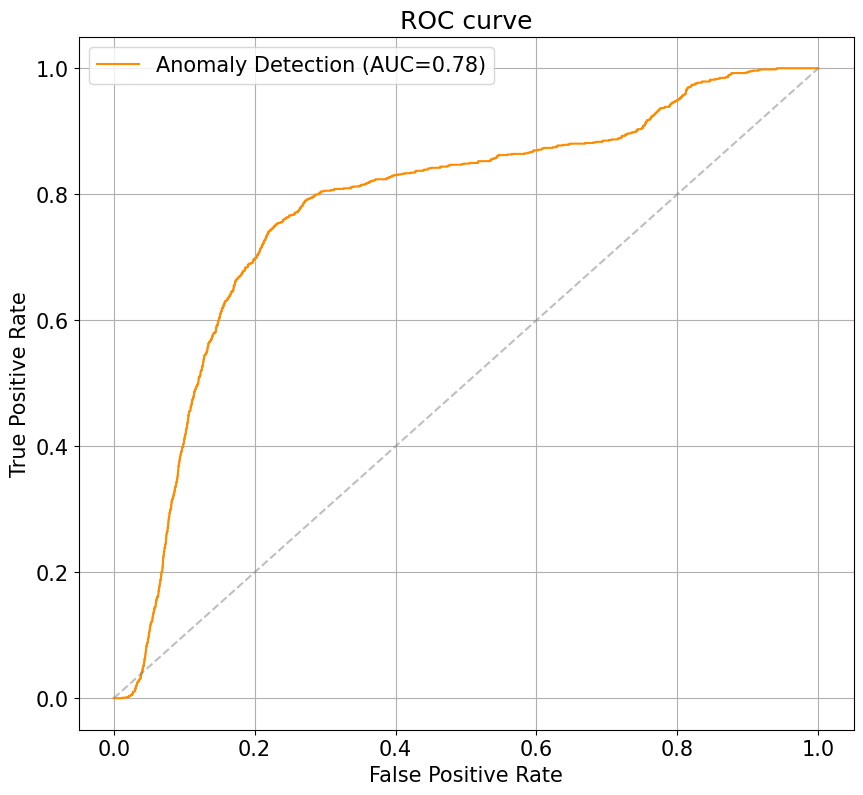

In [ ]:
plt.figure(figsize=(10,9))
plt.rcParams['font.size'] = 15
fpr,tpr,thr = roc_curve(predictions['true_class'], predictions['prob'], pos_label=None, sample_weight=None, drop_intermediate=True)

plt.grid()
plt.plot(fpr,tpr,color='darkorange')
plt.plot((0,1),(0,1),linestyle='--',color='grey',alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend([f'Anomaly Detection (AUC={auc(fpr,tpr):.2f})'])

plt.title("ROC curve")
plt.show()

In [ ]:
plt.figure(figsize=(10,9))
plt.rcParams['font.size'] = 15
prec,rec,thr = precision_recall_curve(predictions['true_class'], predictions['prob'])

plt.grid()
plt.plot(prec,rec,color='darkorange')
plt.plot((0,1),(0,1),linestyle='--',color='grey',alpha=0.5)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend([f'Anomaly Detection'])

plt.title("Precision/Recall curve")
plt.show()

In [ ]:
th = thr[np.argmax(tpr-fpr)]
y_pred = predictions['prob']>th
y_true = predictions['true_class']

print(f"Best probability threshold: p={th*100:.2f}%")
cm = confusion_matrix(y_true,y_pred)
disp  = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

print("\nClassification Report")
print(classification_report(y_true,y_pred))

Best probability threshold: p=2.46%


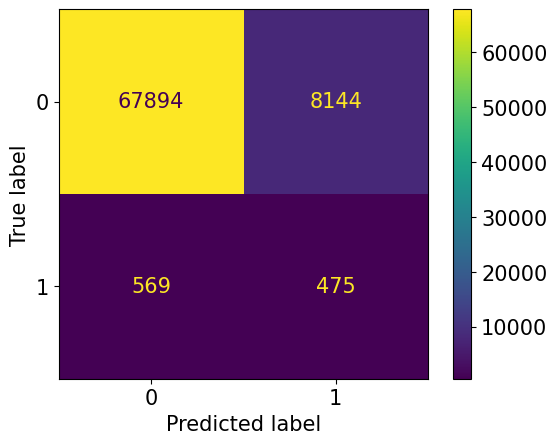

In [ ]:
plt.figure(figsize=(10,10))
plt.yscale('log')
predictions['prob'].hist(bins = 200,color='black')
predictions[predictions['true_class']==0]['prob'].hist(bins = 200,color='lime',alpha=0.7,)
predictions[predictions['true_class']==1]['prob'].hist(bins = 200,color='red',alpha=0.7)
ylim = plt.gca().get_ylim()

plt.vlines(th, *ylim,color='blue')
plt.gca().set_ylim(ylim)
plt.legend(['Threshold','Global Distrib.','False Distrib.','True Distrib.'])

## Error Analysis

In [ ]:
train_labels = []
for g in tqdm(train_loader,leave=False):
  train_labels.append(g.y)
train_labels = torch.cat(train_labels)
test_labels = []
for g in tqdm(test_loader,leave=False):
  test_labels.append(g.y)
test_labels = torch.cat(test_labels)

train_ones = len(train_labels.nonzero())
train_zeros = len(train_labels)-train_ones

test_ones = len((test_labels.nonzero()))
test_zeros = len(test_labels)-test_ones
print('\t0\t\t1')
print(f'train\t{train_zeros} ({train_zeros/len(train_labels)*100:.2f}%)\t{train_ones} ({train_ones/len(train_labels)*100:.2f}%)')
print(f'test\t{test_zeros} ({test_zeros/len(test_labels)*100:.2f}%)\t{test_ones} ({test_ones/len(test_labels)*100:.2f}%)')


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

	0		1
train	178141 (99.06%)	1688 (0.94%)
test	76038 (98.65%)	1044 (1.35%)
